# Clustering Neighborhoods for supporting tourists decisions
### Applied Data Science Capstone by IBM/Coursera
 

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Clustering](#regression)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The objective of this work is to provide a cluster analysis of Toronto’s neighborhoods in order to support tourists decision in choosing a place to stay in a vacation travel.

Gathering data from Foursquare API, containing venues in the neighborhood, venues category and also venues price. I’ll also get the location of all subway and bus stations and tourist attractions. With all this information, I’ll apply k-Means clustering and label neighborhoods according to price, venues variability, mobility and proximity to tourist attractions.

## Data <a name="data"></a>

Three different sources will be required for this project. With all of them gathered together, it will be possible to assemble a model to use in the k-Means clustering algorithm.

First, the list with all postal codes, boroughs and neighborhoodsd of Toronto. This list is avaiable in wikipedia, and the table with all this information will be scraped with BeautifulSoup library.

After this, data will be acquiered by the Foursquare API. I’ll get all venues related with tourism activities: restaurants, malls, tourist attractions, beachs and parks. I’ll also use premium calls in the Foursquare API to retrieve food related venues prices.

Finally, I’ll use transitland database to get all subways and bus station, in order to measure the mobility of each neighborhood.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### The code used to scrape the table from wikipedia is in the project repository in GitHub. In this notebook, I got the scraped table in .csv

In [2]:
#toronto_neighborhoods.csv was scraped from wikipidia
df = pd.read_csv('toronto_neighborhoods.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
df = df.drop(df[df.loc[:, 'Borough'] == 'Not assigned'].index, axis=0)

In [5]:
# This next line shows that there is no case where one postal code is repeated
(df.groupby(df['Postal Code']).count()['Borough'] > 1).sum()

0

In [6]:
# And there's no neighborhodd not assigned
df.loc[df['Neighborhood'] == 'Not assigned']

,Postal Code,Borough,Neighborhood


In [7]:
df.reset_index(drop=True, inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [ ]:
df.shape

### Getting the latitude and the longitude coordinates of each neighborhood
I used the .csv file provided by Coursera to get Latitude and Logintude data and then merged it with the neighborhoods table.

In [8]:
df2 = pd.read_csv("Geospatial_Coordinates.csv")

In [9]:
df = df.merge(df2, on='Postal Code')

In [10]:
df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


### Exploring the city

In [12]:
# create map of Toronto using latitude and longitude values
import folium

latitude = 43.651070
longitude = -79.347015
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### We will have to use the hierarchial categories of foursquare to reduce the categories in each neighborhood

In the Foursquare API documentation, it's provided a hierarchial classification of venues categories. Since the categories don't need to be to specific for tourist purposes, I'll use this hierarchy. All categories come down to 10: 


*Arts & Entertainment, College & University, Event, Food, Nightlife Spot, Outdoors & Recreation, Professional & Other Places, Residence, Shop & Service and Travel & Transport.*

I'll use the API to get a .json file with all sub-categories in each of the category above:

In [13]:
CLIENT_ID = 'N2N35ZIRPE1ZQ1SXJQXLDRJ1QAMYGOLDDLWFESWTAMSIRX2O'     # Foursquare ID
CLIENT_SECRET = 'MBWOJMVLW4R5HPKGQBIGBLUMVEDZ2FUDHFLYSHGK5PEXKE1E' # Foursquare Secret
VERSION = '20180605'

url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION)

In [14]:
import requests
hierarchy = requests.get(url).json()

In [15]:
#A recursive function to get all the id's of categories
def get_id(categories, categories_list):
    
    if len(categories) == 0:
        return
    else:
        for category in categories:
            categories_list.append(category['id'])
            get_id(category['categories'], categories_list)

In [16]:
#I'll create a dict with 10 top categories in the hierarchy to classify the neighborhood.
#Inside each key, there are all the id's of subcategories provided by Foursquare

categories_dict = {}
for item in range(10): 
    top = hierarchy['response']['categories'][item]
    categories_dict[top['name']] = []
    categories_dict[top['name']].append(top['id'])
    get_id(top['categories'], categories_dict[top['name']])
    

#### I'll explore all the boroughs. Since we are interested in classifying the venues according to the hierarchies, we will get just category id and also the venue id, that will be necessary to make premium calls to get the price.

In [17]:
#Defining a getNearbyVenues function, to get the data of FourSquare
import requests

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue id', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category id']
    
    return(nearby_venues)

In [ ]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude']
                                )

I saved a .csv file so I don't have to do Foursquare calls every time I run the notebook.

In [ ]:
toronto_venues.to_csv('toronto_venues.csv')

In [18]:
toronto_venues = pd.read_csv('toronto_venues.csv')

#### Let's see how many venues were returned for each neighborhood

In [19]:
toronto_venues.groupby('Neighborhood').count()

,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Venue id,Venue Latitude,Venue Longitude,Venue Category id
Neighborhood,,,,,,,
Agincourt,4,4,4,4,4,4,4
"Alderwood, Long Branch",9,9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25,25
...,...,...,...,...,...,...,...
"Willowdale, Willowdale East",35,35,35,35,35,35,35
"Willowdale, Willowdale West",7,7,7,7,7,7,7
Woburn,4,4,4,4,4,4,4


In [20]:
toronto_copy = toronto_venues.copy()

#### And also let's check the number of unique venues

In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category id'].unique())))

There are 262 uniques categories.


Here, with the dictionary of categories, I'll classify all of the venues within the top 10 categories:

In [22]:
def hierarchial(row):
    for category in categories_dict:
        if row['Venue Category id'] in categories_dict[category]:
            row['Venue Category_id'] = category
            
    return row

In [23]:
toronto_venues_categories = toronto_copy.apply(hierarchial, axis='columns')

Text(0.5, 0, 'Number of Venues')

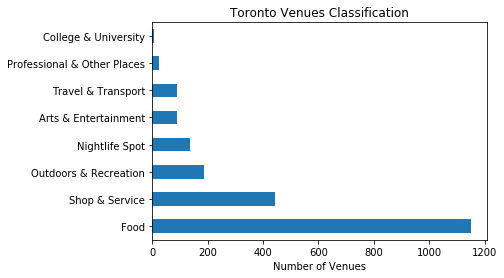

In [52]:
toronto_venues_categories['Venue Category_id'].value_counts().plot(kind='barh')
plt.title('Toronto Venues Classification')
plt.xlabel('Number of Venues')

#plt.savefig('venues_categories.png', bbox_inches="tight")

### Restaurant Prices:
The only way to get a venue price is through a premium call. Since only 500 are allowed per day, I devided the data in 4 parts, and, after getting all the prices, they were merged.

In [26]:
toronto_food = toronto_venues_categories.loc[toronto_venues_categories['Venue Category_id'] == 'Food']

In [27]:
# This function make premium calls to get venues price range (1-4)

def getting_price(row):
    venue_id = row['Venue id']
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

    result = requests.get(url).json()
    
    try:
        row['price'] = result['response']['venue']['price']['tier']
    except:
        row['price'] = 0

    return row

In [ ]:
toronto_food_1st = toronto_food[0:480]
toronto_food_1st= toronto_food_1st.apply(getting_price, axis='columns')

In [ ]:
toronto_food_1st = toronto_food_1st.loc[:940, :]

In [ ]:
#I had to save each data because of the limitation of premium calls per day
toronto_food_1st.to_csv('toronto_food_1st.csv')

In [28]:
toronto_food_1st = pd.read_csv('toronto_food_1st.csv')

In [ ]:
toronto_food_2nd = toronto_food[470:971]
toronto_food_2nd = toronto_food_2nd.apply(getting_price, axis='columns')

In [ ]:
toronto_food_2nd.to_csv('toronto_food_2nd.csv')

In [29]:
toronto_food_2nd = pd.read_csv('toronto_food_2nd.csv')

In [ ]:
toronto_food_3rd = toronto_food.loc[1881:]
toronto_food_3rd = toronto_food_3rd.apply(getting_price, axis='columns')

In [ ]:
toronto_food_3rd.to_csv('toronto_food_3rd.csv')

In [30]:
toronto_food_3rd = pd.read_csv('toronto_food_3rd.csv')

In [31]:
frames = [toronto_food_3rd, toronto_food_2nd, toronto_food_1st]
toronto_food_price = pd.concat(frames, sort=True)

In [32]:
toronto_food_price = toronto_food_price.groupby('Neighborhood')['price'].mean().reset_index()

In [33]:
toronto_food_price

,Neighborhood,price
0,Agincourt,1.500000
1,"Bathurst Manor, Wilson Heights, Downsview North",1.250000
2,Bayview Village,1.333333
3,"Bedford Park, Lawrence Manor East",1.611111
4,Berczy Park,1.586207
...,...,...
70,Westmount,1.200000
71,"Wexford, Maryvale",1.333333
72,"Willowdale, Willowdale East",1.480000
73,"Willowdale, Willowdale West",1.000000


### Mobility with transit.land

Now, I'll have to get the number os bus and subway stations in each neighborhood. I'll do it through the transit.land API.

In [34]:
#This fuction is used to get the number of bus and subway station in each neighborhood, within a radius of 1 km.

import re

def getBusAndSubway(row):
    
    
            
    # create the API request URL
    url = 'https://transit.land/api/v1/stops?lon={}&lat={}&r=1000'.format(row.Longitude, row.Latitude)
                
    
    # make the GET request
    results = requests.get(url).json()
    
    #Since I'll need only the number os bus and subway stations, I'll count them by looking the matches in the
    #.json file
    
    regex_bus = re.compile(r'bus')
    regex_subway = re.compile(r'metro')
    row['#_Bus'] = len(regex_bus.findall(str(results)))
    row['#_Subway'] = len(regex_subway.findall(str(results)))
        
    #returning columns with the number of bus and subway stations
    
    return(row)

In [35]:
neighborhood_mobility = df.copy()

In [ ]:
neighborhood_mobility = neighborhood_mobility.apply(getBusAndSubway, axis=1)

In [ ]:
neighborhood_mobility.to_csv('neighborhood_mobility.csv')

In [36]:
neighborhood_mobility = pd.read_csv('neighborhood_mobility.csv')

In [37]:
neighborhood_mobility

,Unnamed: 0,Postal Code,Borough,Neighborhood,Latitude,Longitude,#_Bus,#_Subway
0,0,M3A,North York,Parkwoods,43.753259,-79.329656,45,0
1,1,M4A,North York,Victoria Village,43.725882,-79.315572,42,0
2,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,22,0
3,3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,50,0
4,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,27,18
...,...,...,...,...,...,...,...,...
98,98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0,0
99,99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,0
100,100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,0,0
101,101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,0,0


### Merging the data from all data sources

Now, we have to merge the data from the venues, food prices and mobility, to complete the dataset.
The datasets are:

1) toronto_venues

2) toronto_food_price

3) neighborhood_mobility

Let's first merge neighborhood_mobility and toronto_food_price:

In [38]:
toronto_data = pd.merge(neighborhood_mobility, toronto_food_price, how='left')

In [39]:
toronto_data

,Unnamed: 0,Postal Code,Borough,Neighborhood,Latitude,Longitude,#_Bus,#_Subway,price
0,0,M3A,North York,Parkwoods,43.753259,-79.329656,45,0,NaN
1,1,M4A,North York,Victoria Village,43.725882,-79.315572,42,0,2.000000
2,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,22,0,1.400000
3,3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,50,0,1.500000
4,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,27,18,1.200000
...,...,...,...,...,...,...,...,...,...
98,98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0,0,NaN
99,99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,0,1.512195
100,100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,0,0,1.500000
101,101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,0,0,NaN


In [40]:
toronto_data.drop(['Postal Code', 'Unnamed: 0', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [41]:
toronto_data.fillna(0, axis=0, inplace=True)

Now, let's normalize this data to then merge with venues categories:

In [42]:
bus_max = toronto_data['#_Bus'].max()
subway_max = toronto_data['#_Subway'].max()
price_max = toronto_data['price'].max()

In [43]:
toronto_data['#_Bus'] = toronto_data['#_Bus'] / bus_max
toronto_data['#_Subway'] = toronto_data['#_Subway'] / subway_max
toronto_data['price'] = toronto_data['price'] / price_max

In [44]:
toronto_data.describe()

,#_Bus,#_Subway,price
count,103.000000,103.000000,103.000000
mean,0.143537,0.022114,0.544769
std,0.315991,0.116259,0.329286
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.500000
50%,0.000000,0.000000,0.666667
75%,0.000000,0.000000,0.750000
max,1.000000,1.000000,1.000000


Let's check the price distribution:

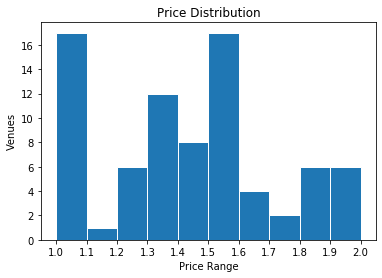

In [51]:
(fig, ax) = plt.subplots()

ax.hist(2*toronto_data.loc[toronto_data['price'] != 0, 'price'], edgecolor='white')

plt.title('Price Distribution')
plt.xlabel('Price Range')
plt.ylabel('Venues')
plt.xticks(np.arange(1,2.1,0.1))
plt.show()

#fig.savefig('price_distribution.png')

Now, let's check the neighborhoods with more mobility options:

Text(0.5, 1.0, 'Top 10 Neighborhoods in Number of Bus Stations in Toronto')

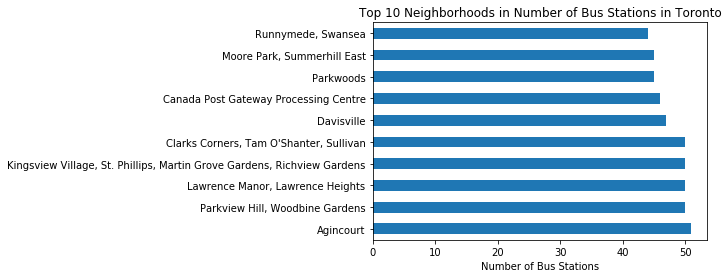

In [50]:
bus_neighborhood = toronto_data[['Neighborhood', '#_Bus']].sort_values(by='#_Bus', ascending=False)
bus_neighborhood['#_Bus'] = bus_neighborhood['#_Bus'] * bus_max
bus_neighborhood = bus_neighborhood.set_index('Neighborhood', drop=True)
bus_neighborhood.head(10).plot(kind='barh')
plt.xlabel('Number of Bus Stations') 
plt.ylabel('')
plt.legend().remove()
plt.title('Top 10 Neighborhoods in Number of Bus Stations in Toronto')

#plt.savefig('top10_bus.png', bbox_inches="tight")

Text(0.5, 1.0, 'Top 5 Neighborhoods in Number of Subway Stations in Toronto')

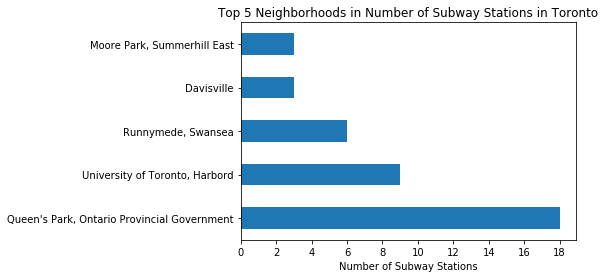

In [48]:
subway_neighborhood = toronto_data[['Neighborhood', '#_Subway']].sort_values(by='#_Subway', ascending=False)
subway_neighborhood['#_Subway'] = subway_neighborhood['#_Subway'] * subway_max
subway_neighborhood = subway_neighborhood.set_index('Neighborhood', drop=True)
subway_neighborhood.head(5).plot(kind='barh')
plt.xticks(np.arange(0, 19, 2))
plt.xlabel('Number of Subway Stations') 
plt.ylabel('')
plt.legend().remove()
plt.title('Top 5 Neighborhoods in Number of Subway Stations in Toronto')

#plt.savefig('top5_subway.png', bbox_inches="tight")

The same procedure of normalization and grouping can be done with venues categories:

In [53]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_categories[['Venue Category_id']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_categories['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head(50)

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Parkwoods,0,0,0,0,1,0,0,0
1,Parkwoods,0,0,0,0,0,0,1,0
2,Victoria Village,1,0,0,0,0,0,0,0
3,Victoria Village,0,0,1,0,0,0,0,0
4,Victoria Village,0,0,1,0,0,0,0,0
5,Victoria Village,0,0,1,0,0,0,0,0
6,"Regent Park, Harbourfront",0,0,1,0,0,0,0,0
7,"Regent Park, Harbourfront",0,0,1,0,0,0,0,0
8,"Regent Park, Harbourfront",0,0,0,0,0,1,0,0
9,"Regent Park, Harbourfront",0,0,0,0,0,0,1,0


In [54]:
toronto_onehot.groupby('Neighborhood').count()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Neighborhood,,,,,,,,
Agincourt,4,4,4,4,4,4,4,4
"Alderwood, Long Branch",9,9,9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25,25,25
...,...,...,...,...,...,...,...,...
"Willowdale, Willowdale East",35,35,35,35,35,35,35,35
"Willowdale, Willowdale West",7,7,7,7,7,7,7,7
Woburn,4,4,4,4,4,4,4,4


#### Grouping Venues by neighborhood

In [55]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Agincourt,0.000000,0.0,0.500000,0.250000,0.250000,0.0,0.000000,0.000000
1,"Alderwood, Long Branch",0.111111,0.0,0.444444,0.111111,0.222222,0.0,0.111111,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0,0.578947,0.000000,0.000000,0.0,0.421053,0.000000
3,Bayview Village,0.000000,0.0,0.750000,0.000000,0.000000,0.0,0.250000,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.720000,0.040000,0.000000,0.0,0.240000,0.000000
...,...,...,...,...,...,...,...,...,...
89,"Willowdale, Willowdale East",0.028571,0.0,0.714286,0.028571,0.028571,0.0,0.171429,0.028571
90,"Willowdale, Willowdale West",0.000000,0.0,0.285714,0.000000,0.000000,0.0,0.714286,0.000000
91,Woburn,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
92,Woodbine Heights,0.000000,0.0,0.000000,0.000000,0.625000,0.0,0.375000,0.000000


### Now, let's print each neighborhood with its most commum venues

In [56]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                   venue  freq
0                   Food  0.50
1         Nightlife Spot  0.25
2  Outdoors & Recreation  0.25
3   Arts & Entertainment  0.00
4   College & University  0.00


----Alderwood, Long Branch----
                   venue  freq
0                   Food  0.44
1  Outdoors & Recreation  0.22
2   Arts & Entertainment  0.11
3         Nightlife Spot  0.11
4         Shop & Service  0.11


----Bathurst Manor, Wilson Heights, Downsview North----
                  venue  freq
0                  Food  0.58
1        Shop & Service  0.42
2  Arts & Entertainment  0.00
3  College & University  0.00
4        Nightlife Spot  0.00


----Bayview Village----
                  venue  freq
0                  Food  0.75
1        Shop & Service  0.25
2  Arts & Entertainment  0.00
3  College & University  0.00
4        Nightlife Spot  0.00


----Bedford Park, Lawrence Manor East----
                  venue  freq
0                  Food  0.72
1        Shop & Service  0.24

4                   Food  0.00


----Humewood-Cedarvale----
                   venue  freq
0  Outdoors & Recreation  0.67
1   Arts & Entertainment  0.33
2   College & University  0.00
3                   Food  0.00
4         Nightlife Spot  0.00


----India Bazaar, The Beaches West----
                   venue  freq
0                   Food  0.57
1  Outdoors & Recreation  0.14
2         Nightlife Spot  0.10
3         Shop & Service  0.10
4   Arts & Entertainment  0.05


----Kennedy Park, Ionview, East Birchmount Park----
                  venue  freq
0        Shop & Service   0.6
1                  Food   0.4
2  Arts & Entertainment   0.0
3  College & University   0.0
4        Nightlife Spot   0.0


----Kensington Market, Chinatown, Grange Park----
                   venue  freq
0                   Food  0.60
1         Shop & Service  0.23
2         Nightlife Spot  0.10
3  Outdoors & Recreation  0.03
4   Arts & Entertainment  0.02


----Kingsview Village, St. Phillips, Martin Grove Gar

                   venue  freq
0                   Food  0.41
1         Shop & Service  0.32
2  Outdoors & Recreation  0.18
3     Travel & Transport  0.09
4   Arts & Entertainment  0.00


----Toronto Dominion Centre, Design Exchange----
                  venue  freq
0                  Food  0.63
1    Travel & Transport  0.10
2        Shop & Service  0.08
3  Arts & Entertainment  0.07
4        Nightlife Spot  0.07


----University of Toronto, Harbord----
                  venue  freq
0                  Food  0.60
1        Nightlife Spot  0.14
2        Shop & Service  0.14
3  College & University  0.06
4  Arts & Entertainment  0.03


----Victoria Village----
                   venue  freq
0                   Food  0.75
1   Arts & Entertainment  0.25
2   College & University  0.00
3         Nightlife Spot  0.00
4  Outdoors & Recreation  0.00


----Westmount----
                  venue  freq
0                  Food  0.71
1        Shop & Service  0.14
2    Travel & Transport  0.14
3  Arts &

### From here we can have a pretty good idea about each neighboorhood. Now, let's transform all this info in a pandas DataFrame

###### First, let' define a function to sort the venues in descending order

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Now, it's possible to create a data frame with the top 10 venues for neighborhood

In [58]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Food,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Shop & Service
1,"Alderwood, Long Branch",Food,Outdoors & Recreation,Shop & Service,Nightlife Spot,Arts & Entertainment
2,"Bathurst Manor, Wilson Heights, Downsview North",Food,Shop & Service,Travel & Transport,Professional & Other Places,Outdoors & Recreation
3,Bayview Village,Food,Shop & Service,Travel & Transport,Professional & Other Places,Outdoors & Recreation
4,"Bedford Park, Lawrence Manor East",Food,Shop & Service,Nightlife Spot,Travel & Transport,Professional & Other Places


Now, the last step before start clustering, is merge the toronto_data DataFrame, that contains all the data about mobility and food prices, and the data about venues.

In [59]:
toronto_clustering = pd.merge(toronto_data, toronto_grouped)

Let's check if there is any repeated neighborhood, and, if there is, it must be droped:

In [60]:
toronto_clustering = toronto_data.set_index('Neighborhood', drop=True, verify_integrity=True)

ValueError: Index has duplicate keys: Index(['Don Mills', 'Downsview'], dtype='object', name='Neighborhood')

Since there are repeated neighborhoods, we must exclude them:

In [61]:
toronto_clustering[toronto_clustering['Neighborhood'] == 'Downsview']

,Borough,Neighborhood,#_Bus,#_Subway,price,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
38,North York,Downsview,0.0,0.0,0.5,0.0,0.0,0.066667,0.0,0.4,0.0,0.466667,0.066667
39,North York,Downsview,0.0,0.0,0.5,0.0,0.0,0.066667,0.0,0.4,0.0,0.466667,0.066667
40,North York,Downsview,0.0,0.0,0.5,0.0,0.0,0.066667,0.0,0.4,0.0,0.466667,0.066667
41,North York,Downsview,0.0,0.0,0.5,0.0,0.0,0.066667,0.0,0.4,0.0,0.466667,0.066667


In [62]:
toronto_clustering[toronto_clustering['Neighborhood'] == 'Don Mills']

,Borough,Neighborhood,#_Bus,#_Subway,price,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
6,North York,Don Mills,0.666667,0.0,0.923077,0.038462,0.0,0.538462,0.0,0.153846,0.0,0.269231,0.0
7,North York,Don Mills,0.000000,0.0,0.923077,0.038462,0.0,0.538462,0.0,0.153846,0.0,0.269231,0.0


In [63]:
toronto_clustering.drop([7, 39, 40, 41], axis=0, inplace=True)

In [64]:
toronto_clustering

,Borough,Neighborhood,#_Bus,#_Subway,price,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,North York,Parkwoods,0.882353,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000
1,North York,Victoria Village,0.823529,0.0,1.000000,0.250000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Downtown Toronto,"Regent Park, Harbourfront",0.431373,0.0,0.700000,0.111111,0.000000,0.444444,0.044444,0.111111,0.044444,0.222222,0.022222
3,North York,"Lawrence Manor, Lawrence Heights",0.980392,0.0,0.750000,0.000000,0.000000,0.117647,0.000000,0.058824,0.058824,0.764706,0.000000
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.529412,1.0,0.600000,0.060606,0.030303,0.606061,0.060606,0.090909,0.030303,0.121212,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
94,Downtown Toronto,Church and Wellesley,0.000000,0.0,0.756098,0.041096,0.000000,0.561644,0.109589,0.095890,0.013699,0.136986,0.041096
95,East Toronto,"Business reply mail Processing Centre, South C...",0.000000,0.0,0.750000,0.000000,0.000000,0.235294,0.058824,0.235294,0.000000,0.352941,0.117647
96,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


toronto_clustering is the data frame that will be used in the model. There are 11 features, excluding borough and neighborhood:

In [66]:
toronto_clustering.shape 

(94, 13)

Now we can put this into in the neighborhoods_venues_sorted DataFrame.

We can add more information, with price and mobility:
    

In [67]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(toronto_clustering[['Neighborhood', '#_Bus', '#_Subway', 'price']], on='Neighborhood')

In [68]:
#just passing borough to the first row in columns

fixed_columns = [toronto_clustering.columns[9]] + list(toronto_clustering.columns[0:9])
fixed_columns += list(toronto_clustering.columns[10:])
    
toronto_clustering = toronto_clustering[fixed_columns]

## Clustering <a name="regression"></a>

### Now, we can cluster our neighborhoods

In [69]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

Let's, first, find the best k:

In [70]:
wcss = []

toronto_k_means = toronto_clustering.drop(['Borough', 'Neighborhood'], 1)

for i in range(1, 11):
    
    kmeans = KMeans(n_clusters=i, random_state=0).fit(toronto_k_means)
    
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)

1 40.06457406498896
2 24.823244865875992
3 16.9577184424165
4 14.770967243310412
5 13.172134143231812
6 11.71211415177935
7 10.640597304512928
8 9.490909262240283
9 8.709374550316298
10 7.80987692362682


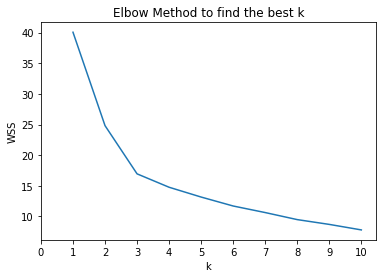

In [72]:
(fig, ax) = plt.subplots()

ax.plot(range(1, 11), wcss)
plt.title('Elbow Method to find the best k')
plt.xlabel('k')
plt.ylabel('WSS') #within cluster sum of squares
plt.xticks(np.arange(0, 11, 1))
plt.show()

#fig.savefig('elbow_method.png')

In [73]:
# set number of clusters
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_k_means)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 2, 2, 2, 2, 2, 2, 0, 0], dtype=int32)

In [74]:
df = df.sort_values(by='Neighborhood').reset_index(drop=True)

In [75]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,#_Bus,#_Subway,price
0,M1S,Scarborough,Agincourt,43.794200,-79.262029,1.0,Food,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Shop & Service,1.0,0.0,0.750000
1,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,2.0,Food,Outdoors & Recreation,Shop & Service,Nightlife Spot,Arts & Entertainment,0.0,0.0,0.000000
2,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,2.0,Food,Shop & Service,Travel & Transport,Professional & Other Places,Outdoors & Recreation,0.0,0.0,0.625000
3,M2K,North York,Bayview Village,43.786947,-79.385975,2.0,Food,Shop & Service,Travel & Transport,Professional & Other Places,Outdoors & Recreation,0.0,0.0,0.666667
4,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,2.0,Food,Shop & Service,Nightlife Spot,Travel & Transport,Professional & Other Places,0.0,0.0,0.805556


From here we can check how many neighborhoods each cluster label has:

In [77]:
toronto_merged['Cluster Labels'].value_counts()

0    63
1    20
2    15
Name: Cluster Labels, dtype: int64

#### From the verification above, we can conclude that there's a neighborhood without cluster, because no venues were returned. We can, then, drop it

In [78]:
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype('int')

In [79]:
#Simple function to display the price range in each neighborhood in the Popup

def get_price(price):
    if price < 0.5:
        return '$'
    elif price < 0.75:
        return '$$'
    else:
        return '$$$'


In [80]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, price in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'], toronto_merged['price']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' ' + get_price(price), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Now, let's analyze each cluster

In [81]:
toronto_merged.columns

Index(['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '#_Bus', '#_Subway', 'price'],
      dtype='object')

In [82]:
clusters = toronto_merged.groupby('Cluster Labels').aggregate({'1st Most Common Venue': pd.Series.mode, '2nd Most Common Venue': pd.Series.mode,
                                                    '3rd Most Common Venue': pd.Series.mode, '#_Bus': 'mean', '#_Subway': 'mean',
                                                    'price': 'mean'})


In [84]:
clusters['Cluster Labels'] = pd.Series(['Red', 'Purple', 'Blue'])

In [85]:
clusters

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,#_Bus,#_Subway,price,Cluster Labels
Cluster Labels,,,,,,,
0,Food,Shop & Service,Outdoors & Recreation,0.148459,0.030864,0.560112,Red
1,Food,Shop & Service,Travel & Transport,0.225490,0.000000,0.604491,Purple
2,Food,Shop & Service,"[Nightlife Spot, Travel & Transport]",0.057516,0.022222,0.582284,Blue


## Results and Discussion <a name="results"></a>

About venues, we can see that 1st and 2nd most commom venues are Food and Shop & Services. The difference comes in the 3rd most commum venues. For Red Cluster, it's Outdoors and Recreation. As for Purple Cluster, it's Travel & Transport. Finally, for Blue Cluster, we have a tie: Travel & Transport and Nightlife Spot.

Regarding the mobility, this numbers represent the mean for each cluster of the normalized number of bus and subway stations. For the Purple Cluster, we have the highest number of bus stations, but no subway stations at all. The Red Cluster is the second in bus stations options, and the first in number of subway stations. As for the Blue Cluster, there are few options of both subway and bus stations.

Finally, we can analyze the price. The most expensive cluster is the Purple one. It's good to keep in mind that this Cluster don't have subway stations, so it can become even more expensive. The second when it comes to price is the Blue Cluster. And, the cheapest one is the Red Cluster.

## Conclusion <a name="conclusion"></a>

In this study, I analyzed the neighborhoods in Toronto, and clustered them according to variability of venues in each neighborhood, mobility and venues prices.
This classification provide insight to tourists. When choosing a place to stay on Airbnb, or book a hotel, it is possible to know a priori the characteristics of the neighborhood, and take this into account when planning your trip.

If you are a young tourist who likes to go out at night, perhaps the Blue Cluster is a good option. However, if you don't have that much money, taking advantage of Red Cluster's low prices and mobility options will help keep you within budget.